In [3]:
import sys
print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import(
  QuantumCircuit,
  QuantumRegister, ClassicalRegister,
  execute,
  Aer)
from qiskit.visualization import plot_histogram
from qiskit.circuit import Gate

3.8.1 (tags/v3.8.1:1b293b6006, Jan  6 2020, 11:40:25) 
[GCC 9.2.1 20191008]


In [4]:
# example of a ccx/toffoli gate

amount_of_qbits = 3

# build the main circuit
circuit = QuantumCircuit(amount_of_qbits)

# circuit.toffoli(2,1,0)
circuit.ccx(0,1,2)

# Draw the circuit
# circuit.draw(output="mpl")
circuit.draw(output="text")

q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘

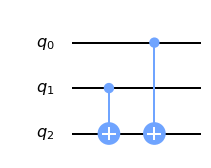

In [5]:
# example of 2 cnot gates

amount_of_qbits = 3

# build the main circuit
circuit = QuantumCircuit(amount_of_qbits)

circuit.cx(1,2)
circuit.cx(0,2)

# Draw the circuit
circuit.draw(output="mpl")
# circuit.draw(output="text")

In [6]:
# There is an option to create a gate out of a circuit.
# In the following case it is not necessary, though I used it for educational purposes.

# Let us create a Sqrt_X gate
def create_sqrt_x():
    c = QuantumCircuit(1, name="Sqrt_X") # this gate operates on 1 qbit
    # apply the relevant logic.
    c.u2( # more about u2 later.
        phi=-np.pi/2,
        lam=np.pi/2,
        qubit=0
    )
    # save this circuit as a gate
    return c.to_gate()

sqrt_x = create_sqrt_x()

# About u2.
# There are 3 u-gates. u1, u2, u3.
# Their implementation can be found at:
# https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library/standard_gates
# Further details can be found here:
# https://quantum-computing.ibm.com/docs/iqx/q-gates#u2-gate
# https://qiskit.org/documentation/stubs/qiskit.circuit.library.U2Gate.html
#
# Their example tells us that: U2(-\pi/2, \pi/2) = RX(\pi/2)
# This would translate to:
# RZ(-pi/2).RY(pi/2).RZ(pi/2)
# In other words, it would 

# example: using sqrt_x
def create_circuit():
    c = QuantumCircuit(1)
    # append our gate, with a list of qbits to operate on.
    # the length of the list has to equal sqrt_x.num_qubits.
    c.append(sqrt_x, [0])
    c.draw()
    return c

# creating the inverse of sqrt_x:
#sqrt_x.inverse()
# creating a controlled-sqrt_x:
#sqrt_x.control()
# creating a controlled-inverse-sqrt_x:
#sqrt_x.inverse().control()

input : 000
output: 000 & 001


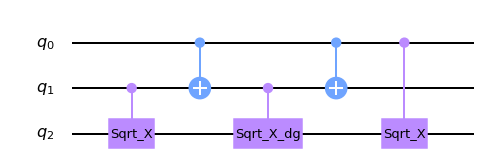

In [7]:
# helper functions
def outputstate_to_bin(outputstate):
    # get amount of bits
    l = np.log2(len(outputstate))
    # find every index where there is a non-zero probability
    #indexes = np.where(res != 0)[0]
    indexes = np.where(outputstate)[0]
    # convert it to bin
    s = [bin(i)[2:] for i in indexes]
    # pad with zeros
    s = [
        '0'*int(l-len(i)) + i
        for i in s
    ]
    # move lowest bit to the right
    s = [i[::-1] for i in s]
    # return all the results
    return ' & '.join(s)

def get_results(circuit):
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(circuit, simulator)
    result = job.result()
    outputstate = result.get_statevector(circuit, decimals=3)
    return outputstate_to_bin(outputstate)

def print_toffoli_circuit(i2=0, i1=0, i0=0, sqrt=False):
    amount_of_qbits = 3
    circuit = QuantumCircuit(amount_of_qbits)
    
    if i0:
        circuit.x(0)
    if i1:
        circuit.x(1)
    if i2:
        circuit.x(2)

    if sqrt:
        circuit.append(sqrt_x.control(), [1,2])
        circuit.cx(0,1)
        circuit.append(sqrt_x.inverse().control(), [1,2])
        circuit.cx(0,1)
        circuit.append(sqrt_x.control(), [0,2])
    else:
        circuit.cx(1,2)
        circuit.cx(0,1)
        circuit.cx(1,2)
        circuit.cx(0,1)
        circuit.cx(0,2)
    
    print(f"input : {i0}{i1}{i2}")
    print(f"output: {get_results(circuit)}")
    return circuit.draw(output="mpl")


# for i0 in (0,1):
#     for i1 in (0,1):
#         for i2 in (0,1):
#             create_toffoli_gate(i2, i1, i0, False)
create_toffoli_gate(0,0,0, True)

In [40]:
def create_toffoli_gate(gate, control_0=0, control_1=1, target=2):
    circuit = QuantumCircuit(
        amount_of_qbits,
        name="Toffoli^{%s}_{(%s,%s),%s}" % (gate.name, control_0, control_1, target)
    )
    sqrt_gate = gate.power(0.5)
    
    circuit.append(sqrt_gate.control(), [control_1,target])
    circuit.cx(control_0,control_1)
    circuit.append(sqrt_gate.inverse().control(), [control_1,target])
    circuit.cx(control_0,control_1)
    circuit.append(sqrt_gate.control(), [control_0,target])

    return circuit.to_gate()

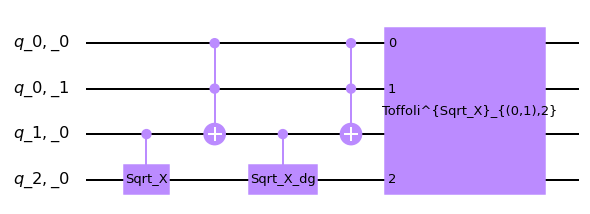

In [41]:
# C^3
zero = QuantumRegister(2, "q_0,")
one  = QuantumRegister(1, "q_1,")
two  = QuantumRegister(1, "q_2,")
circuit = QuantumCircuit(zero, one, two)

# 1 is the control, so it stays the same
circuit.append(sqrt_x.control(), [one,two])
# now zero is the control, so we'll make it a control-control
circuit.ccx(zero[0],zero[1],one)
# 1 is the control, so it stays the same
circuit.append(sqrt_x.inverse().control(), [one,two])
# now zero is the control, so we'll make it a control-control
circuit.ccx(zero[0],zero[1],one)
# now zero is the control, so we'll make it a toffoli gate (since its controlling sqrt_x)
# circuit.append(sqrt_x.control(), [0,2])
circuit.append(create_toffoli_gate(sqrt_x), [0,1,3])

circuit.draw(output="mpl")